#### In First we will import all the libraries we will need

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import neurokit2 as nk
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import joblib
import time
from os.path import exists
import matplotlib.pyplot as plt

#### This function is responsible for extracting ECG data from DREAMER Dataset, it also processing data by neurokit2 package and Heart rate variability analysis and extract features we need.

In [2]:
def feat_extract_ECG(raw):
    data_ECG = {}
    for participant in range(0, 23):
        for video in range(0, 18):
            # load raw baseline and stimuli data for left and right
            stim_left = (raw["DREAMER"][0, 0]["Data"]
                         [0, participant]["ECG"][0, 0]
                         ["stimuli"][0, 0][video, 0][:, 0])
            stim_right = (raw["DREAMER"][0, 0]["Data"]
                          [0, participant]["ECG"][0, 0]
                          ["stimuli"][0, 0][video, 0][:, 1])
            # process with neurokit
            signals_s_l, info_s_l = nk.ecg_process(
                stim_left, sampling_rate=256)
            signals_s_r, info_s_r = nk.ecg_process(
                stim_right, sampling_rate=256)
            # hrv features extraction
            features_ecg_l = nk.ecg_intervalrelated(signals_s_l)
            features_ecg_r = nk.ecg_intervalrelated(signals_s_r)
            # average left and right features
            features_ecg = (features_ecg_l + features_ecg_r)/2
            if not len(data_ECG):
                data_ECG = features_ecg
            else:
                data_ECG = pd.concat([data_ECG, features_ecg],
                                     ignore_index=True)
    return data_ECG

#### this function is responsible for extract participant informations from DREAMER like(age, gender, video_name, emotion, arousal,..) then save them at csv file.

In [3]:
def participant_affective(raw):
    a = np.zeros((23, 18, 9), dtype=object)
    for participant in range(0, 23):
        for video in range(0, 18):
            a[participant, video, 0] = (raw["DREAMER"][0, 0]["Data"]
                                        [0, participant]["Age"][0][0][0])
            a[participant, video, 1] = (raw["DREAMER"][0, 0]["Data"]
                                        [0, participant]["Gender"][0][0][0])
            a[participant, video, 2] = int(participant+1)
            a[participant, video, 3] = int(video+1)
            a[participant, video, 4] = ["Searching for Bobby Fischer",
                                        "D.O.A.", "The Hangover", "The Ring",
                                        "300", "National Lampoon\'s VanWilder",
                                        "Wall-E", "Crash", "My Girl",
                                        "The Fly", "Pride and Prejudice",
                                        "Modern Times", "Remember the Titans",
                                        "Gentlemans Agreement", "Psycho",
                                        "The Bourne Identitiy",
                                        "The Shawshank Redemption",
                                        "The Departed"][video]
            a[participant, video, 5] = ["calmness", "surprise", "amusement",
                                        "fear", "excitement", "disgust",
                                        "happiness", "anger", "sadness",
                                        "disgust", "calmness", "amusement",
                                        "happiness", "anger", "fear",
                                        "excitement", "sadness",
                                        "surprise"][video]
            a[participant, video, 6] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreValence"]
                                           [0, 0][video, 0])
            a[participant, video, 7] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreArousal"]
                                           [0, 0][video, 0])
            a[participant, video, 8] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreDominance"]
                                           [0, 0][video, 0])
    b = pd.DataFrame(a.reshape((23*18, a.shape[2])),
                     columns=["age", "gender", "participant",
                              "video", "video_name", "target_emotion",
                              "valence", "arousal", "dominance"])
    return b


#### This function customization ML features that we will work on

In [4]:
def customiz_data_ML(data):
    data = pd.DataFrame(data, columns=[
        'ECG_Rate_Mean', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
        'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_HTI', 
        'HRV_HF', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S', 
        'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS', 'HRV_PSS', 
        'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a',
        'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa',
        'HRV_DFA_alpha1', 'HRV_DFA_alpha1_ExpRange', 'HRV_DFA_alpha1_ExpMean', 'HRV_DFA_alpha1_DimRange',
        'HRV_DFA_alpha1_DimMean', 'HRV_ApEn', 'HRV_SampEn', 'gender', 'age', 'target_emotion', 'valence', 
        'arousal', 'dominance', 'stress_bin', 'participant'
    ])
    return data

#### This function sets the settings for the plot

In [5]:
def plot_settings():
    plt.rcParams['figure.figsize'] = [15, 9]
    plt.rcParams['font.size'] = 13

#### This function is one of the most important functions as it is the one which processes the signals by cleaned ECG channel, filter and minimize noise and detect peaks. 
#### It returns clean signals ready for analysis and feature extraction.


In [6]:
def processing(ecg_signal):
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=256)
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=256)
    rate = nk.ecg_rate(rpeaks, sampling_rate=256,
                       desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=256)

    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality})
    signals = pd.concat([signals, instant_peaks], axis=1)
    info = rpeaks
    return signals, info

#### This function customization to be ready to testing by model

In [7]:
def customiz_data_hrv(data):
    data = pd.DataFrame(data, columns=[
        'ECG_Rate_Mean', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD',
        'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_HTI', 'HRV_HF', 'HRV_HFn', 'HRV_LnHF',
        'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP',
        'HRV_IALS', 'HRV_PSS', 'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 
        'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa',
        'HRV_DFA_alpha1', 'HRV_DFA_alpha1_ExpRange', 'HRV_DFA_alpha1_ExpMean', 'HRV_DFA_alpha1_DimRange', 
        'HRV_DFA_alpha1_DimMean', 'HRV_ApEn', 'HRV_SampEn'
    ])
    return data

#### This function is responsible for loading DREAMER.mat dataset, calling feat_extract_ECG function and participant_affective.

In [8]:
def PE_dreamer(path):
    raw = sio.loadmat(path)
    print("Dataset Load Done")
    print("  ")
    print("Processing and Extarctring Featuers....")
    df_ECG = feat_extract_ECG(raw)
    print("Processing and Extarctring Featuers Done")
    df_features = pd.concat([df_ECG], axis=1)
    df_participant_affective = participant_affective(raw)
    df_participant_affective["valence"] = (df_participant_affective
                                           ["valence"].astype(int))
    df_participant_affective["arousal"] = (df_participant_affective
                                           ["arousal"].astype(int))
    df_participant_affective["dominance"] = (df_participant_affective
                                             ["dominance"].astype(int))
    df = pd.concat([df_features, df_participant_affective], axis=1)

    data = df.loc[(df['target_emotion'] == 'calmness') |
                  (df['target_emotion'] == 'happiness') |
                  (df['target_emotion'] == 'sadness') |
                  (df['target_emotion'] == 'anger') |
                  (df['target_emotion'] == 'fear') |
                  (df['target_emotion'] == 'surprise')
                  ].copy()

    data['stress_bin'] = data['target_emotion'].map(
        {'calmness': 0, 'happiness': 1, 'sadness': 2,
            'anger': 3, 'fear': 4, 'surprise': 5}
    )
    data = customiz_data_ML(data)
    data.to_csv('data/dataML.csv')

#### When we pass the heartbeat to this function, it makes simulated signals and processing it by (processing() function), then analyzes them. 
#### output is the features and stores them in a csv file.

In [9]:
def PF_generated_ecg(heartRate):
    plot_settings()
    ecg = nk.ecg_simulate(sampling_rate=256, heart_rate=heartRate)
    nk.signal_plot(ecg)
    signal, info = processing(ecg)
    nk.ecg_plot(signal[:3000], sampling_rate=256)
    data = nk.ecg_intervalrelated(signal)
    data = customiz_data_hrv(data)
    data.to_csv("data/manual_emotions_signals/generated_ECG_256hz.csv")
    return "data/manual_emotions_signals/generated_ECG_256hz.csv"

##### This function is responsible for processing the extraction of features from the received ECG signals and then storing them in a csv file

In [10]:
def PF_ecg(path):
    plot_settings()
    ecg = pd.read_csv(path)
    nk.signal_plot(ecg['ECG'])
    signal, info = nk.ecg_process(ecg["ECG"], sampling_rate=100)
    nk.ecg_plot(signal[:3000], sampling_rate=100)
    data = nk.ecg_intervalrelated(signal)
    data = customiz_data_hrv(data)
    data.to_csv("data/manual_emotions_signals/PF_ECG_100hz.csv")
    return "data/manual_emotions_signals/PF_ECG_100hz.csv"

#### This function is responsible for split data into (X: features, y: output) and by GroupKFold and split() split data into train and test

In [11]:
def preparing_ML_data(path):
    data = pd.read_csv(path)
    group_kfold = GroupKFold(n_splits=10)
    X = np.array(data.loc[:, 'ECG_Rate_Mean':'HRV_SampEn'])
    y = np.array(data['stress_bin'])
    groups = np.array(data['participant'])
    for train, test in group_kfold.split(X, y, groups):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
    return X, y, groups, X_train, X_test, y_train, y_test

#### This function is responsible for train model and evaluate it by cross-validation
#### Then calculate score (Accuracy) and runtime

In [12]:
def run_clf(clf, X, y, groups, X_test, y_test):
    cv = GroupKFold(n_splits=10)
    score = []
    runtime = []
    for fold, (train, test) in enumerate(cv.split(X, y, groups)):
        clf.fit(X[train], y[train])
        start = time.time()
        score.append(clf.score(X_test, y_test))
        runtime.append(time.time() - start)    
    return score, runtime

#### In this function we define classifier, preparing data by preparing_ML_data() and passes it to run_clf() to do work.

In [13]:
def supervised_model(train_data):    
    results = []
    X, y, groups, X_train, X_test, y_train, y_test = preparing_ML_data(
        train_data)
    model = make_pipeline(MinMaxScaler(feature_range=(-1, 1)), SVC(gamma=2, C=1))
    score, runtime = run_clf(model, X, y, groups, X_test, y_test)
    results.append(["SVC", round(np.mean(score)*100, 1),
                   round(np.mean(runtime), 9)])
    result = pd.DataFrame(results, columns=['Name', 'Score', 'Runtime'])
    return model, result

#### This function job is check if ML data exist or no if it not found will create new one, passes training data to supervised_model() and save model at pkl.

In [14]:
def run(train_path: str, dreamer_path: str):
    
    if(not exists(train_path)):
        print("Trainning Data not found, Will generate new data")
        if(exists(dreamer_path)):
            PE_dreamer(dreamer_path)
        else:
            return "DREAMER Dataset Not Found"
    model_saved, result = supervised_model(train_path)
    joblib.dump(model_saved, 'model.pkl')
    return result

In [15]:
print(run("data/dataML.csv","../Datasets/DREAMER.mat"))

  Name  Score  Runtime
0  SVC   91.7  0.00119


#### 1- Load pkl model by joblib
#### 2- If there are no ecg data it will test by simulate data by default 
#### heart rate.
#### 3- If there is a heart rate will simulate data by this value.
#### 4- If there is a ecg data will pass it to PF_ecg() function to processing, analyzes it and extract required features to testing.
#### 5- Using test data to testing model. 

In [16]:
def app(**kwargs):
    heartrate = kwargs.get('heartrate', 80)
    test_path = kwargs.get('test', "")
    ecg_path = kwargs.get('ecg', "")
    emotions = ['calm', 'happy', 'sad', 'angry', 'fear', 'suprise']
    model = joblib.load('model.pkl')
    if(exists(test_path)):
        path = test_path
    elif(exists(ecg_path)):
        path = PF_ecg(ecg_path)
    else:
        path = PF_generated_ecg(heartrate)
    data = pd.read_csv(path)
    features = np.array(data.loc[:, 'ECG_Rate_Mean':'HRV_SampEn'])
    features = np.nan_to_num(features)
    emotion = model.predict(features)
    return emotions[emotion[0]]

c:\Users\User\anaconda3\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `windows` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\User\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:202: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)


'calm'

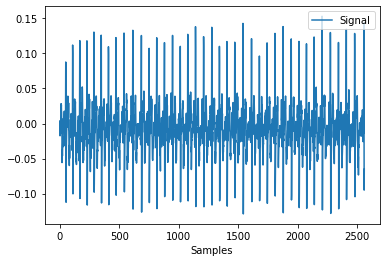

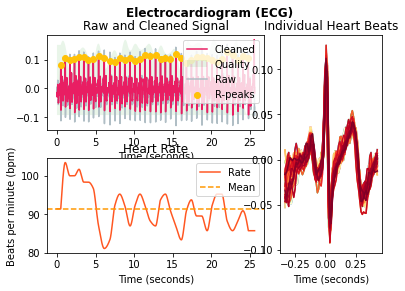

In [17]:
app(ecg = "../Datasets/ecg_100hz.csv")